In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q
import time
from mpl_toolkits.mplot3d import Axes3D
import random as random

In [2]:
# Funcion que, dado un vector y su dimension, me genera una base de vectores ortonormales en la cual este mismo vector es el primero
def generar_base_ortonormal(vector, dim):
    # Normalizar el primer vector
    v1 = vector / np.linalg.norm(vector)
    v1 = np.squeeze(np.asarray(v1, dtype = complex))
    # Generar una matriz aleatoria de dimensión (dim x dim)
    random_matrix = np.matrix(np.random.randn(dim, dim), dtype = complex)

    # Realizar el proceso de Gram-Schmidt para generar los vectores ortogonales restantes
    base = [v1]
    for i in range(1, dim):
        # Obtener el siguiente vector aleatorio
        #v = np.reshape(random_matrix[i], (1, max(random_matrix[i].shape)))
        v = np.squeeze(np.asarray(random_matrix[i], dtype = complex))
        #v = np.asarray(random_matrix[i], dtype = complex)
        #v = np.reshape(v, (1, max(v.shape)))
        # Restar las proyecciones de los vectores anteriores
        for j in range(i):
            v -= np.dot(v, base[j].T) * base[j]

        # Normalizar el vector resultante
        v /= np.linalg.norm(v)

        # Agregar el vector a la base ortonormal
        base.append(v)

    return base


# Funcion que me obtiene el hamiltoniano del modelo de atomos de rydberg
def rydberg(N, params):
    omega = params[0]
    delta = params[1]
    v = params[2]
    k = params[3]
    j = N/2
    
    Sx = q.jmat(j, 'x')
    Sz = q.jmat(j, 'z')
    Sm = q.jmat(j, '-')
    
    H = omega*Sx - delta*Sz + (v/N)*Sz*Sz
    J = np.sqrt(k/N)*Sm
    
    return H, J

def densidad(N):
    return q.basis(int(N+1), 0)*(q.basis(int(N+1), 0)).dag(), q.basis(int(N+1), 0)

# Funcion que me hace lo de Mpemba1 pero con qutip
def Mpemba1_mejorada_q(L, L_e, autovals, d, N, ini):

  # Se obtiene el segundo autovalor con la parte real mayor
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(autovals)))

  # Hacemos reshape
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  vals = todo[0]
  vects = todo[1]
  #vects = [elemento.full() for elemento in todo[1]]
  """
  todo = (sp.Matrix(L1, dtype = complex)).eigenvects()
  vals = [tup[0] for tup in todo]
  vects = np.asarray([tup[2] for tup in todo], dtype = complex)
  vects = [np.reshape(elemento, (1, max(elemento.shape))) for elemento in vects]
  vals = list(np.array(vals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(vals)

  # Ahora, generamos la base auxiliar para el vector ini
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux= [q.Qobj(x) for x in base_aux]
  #base_aux = np.asarray([elemento for elemento in base_aux], dtype = complex)
  U_cambio = vects[0]*(base_aux[0].dag())
  #U_cambio = ketbra((vects[0]), base_aux[0])
  for i in range(1, N):
      U_cambio += vects[i]*(base_aux[i].dag())
    #U_cambio += ketbra((vects[i]), base_aux[i])

  # Ahora, tenemos que dividir en dos caminos, definimos una tolerancia
  #tol = 1.0e-14
  es_cero = [(np.allclose(np.abs(vals[i]), 0.0, atol = 1e-5)) for i in range(len(vals))]

  if(any(es_cero)):
    print('Se puede hacer la vía del cero, con el autovalor: ')
    # Nos vamos al caso en el que un autovalor es 0
    indice = es_cero.index(True)
    #print(vals[indice])
    #print(vals[indice])
    print(vals[indice])
    #U = ketbra(ini, vects[indice][0])
    U = ini*(vects[indice].dag())
    #U = ini*(vects[indice].dag())
    #U = ketbra(ini, vects[indice])
  else:
    print('No se ha podido hacer la via del cero')
    # Si no hay ningun autovalor que sea 0, se coje una pareja de autovalores con signo contrario
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  #return q.Qobj(U), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio
    


# Funcion que nos calcula la transformacion de Mpemba2, pero con qutip
def Mpemba2_mejorada_q(L, L_e, vals, d, N, ini):
   # Extraemos la matriz por la izquierda cuyo autovalor es el mayor (y no es cero)
  
  # segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo(list(np.real(vals)))
  #segundo_maximo, indice_segundo_maximo = buscar_segundo_maximo([np.real(elemento) for elemento in vals])
  #print('Autovalores', vals)
  #print('Segundo maximo', segundo_maximo)
  #indice_segundo_maximo = vals.index(segundo_maximo)
  #print('Indice segundo maximo: ' + str(indice_segundo_maximo))
  L_buenos= []
  for elemento in L_e:
      if(np.allclose(L*elemento, np.zeros_like(L*elemento), atol = 1e-2) == False):
          L_buenos.append(elemento)
  # La pasamos a matriz
  #L1 = np.reshape(L_e[indice_segundo_maximo], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_buenos[0], (d.shape[0], d.shape[1]))
  L1 = np.reshape(L_e[1], (d.shape[0], d.shape[1]))
  #L1 = sp.Matrix(L1, dtype = complex)
  #print('Autovalor asociado al l1: ', L1)

  # Diagonalizamos la matriz L1
  todo = (q.Qobj(L1)).eigenstates(sparse = False, sort = 'low')
  autovals = todo[0]
  autovects = todo[1]
  #autovects = [elemento.full() for elemento in todo[1]]
  """
  todo = L1.eigenvects()
  autovals = [tup[0] for tup in todo]
  autovects = [np.array(tup[2][0], dtype = complex) for tup in todo]
  autovals = list(np.array(autovals, dtype = complex))
  """
  #print('Autovalores de L1: ')
  #print(autovals)

  # Ahora, generamos la base auxiliar para el vector estado inicial
  #base_aux = generar_base_ortonormal_q(ini)
  base_aux = generar_base_ortonormal(ini, N+1)
  base_aux = [q.Qobj(x) for x in base_aux]
  #print('Dimension: ', base_aux[2].shape)
  #base_aux = np.array([elemento for elemento in base_aux], dtype = complex)
  
  # Con esto, podemos generar la primera transformacion
  U_cambio = autovects[0]*base_aux[0].dag()
  #U_cambio = ketbra(autovects[0], base_aux[0])
  for i in range(1, N):
      U_cambio += autovects[i]*(base_aux[i].dag())
      
  #es_cero = [(np.isclose(np.abs(autovals[i]), 0, atol = 1e-4)) for i in range(len(autovals))]

  print('Vamos a probar la via del no cero')
  # Se coje una pareja de autovalores con signo contrario
  i = 0
  #indice_contrario = 0
  #indice_inicial = es_cero.index(False)
  #print(indice_inicial)
  #autovals = eliminar_duplicados(autovals)
  #es_contrario = [np.real(autovals[indice_inicial])*np.real(autovals[i]) < 0 for i in range(len(autovals))]
  if(np.real(autovals[0])*np.real(autovals[-1]) < 0):
    #indice_contrario = es_contrario.index(True)
    #print('(indice contrario, indice inicial, len(autovects)) = ' + str(indice_contrario) + ', ' + str(indice_inicial) + ', '  + ' ' + str(autovects[0].shape))
    F = autovects[0]*autovects[-1].dag() + autovects[-1]*autovects[0].dag()
    #F = autovects[indice_inicial]*autovects[indice_contrario].dag() + autovects[indice_contrario]*autovects[indice_inicial].dag()
    #F = ketbra(autovects[indice_inicial], autovects[indice_contrario]) + ketbra(autovects[indice_contrario], autovects[indice_inicial])
    s = np.arctan(np.sqrt((np.abs(autovals[0]))/(np.abs(autovals[-1]))))
    #s = np.arctan(np.sqrt((np.abs(autovals[indice_inicial]))/(np.abs(autovals[indice_contrario]))))
    print("La s me sale: " + str(s) + ' se ha cogido la s que sale de los autovalores: ')
    #print((autovals[indice_inicial], autovals[indice_contrario]))
    #print(F)
    #identidad = kronecker(iden, 0, N)
    identidad = q.qeye(F.shape[0])
    U = identidad + (np.cos(s) - 1.0)*(F*F) - 1.j*np.sin(s)*F
    #U = identidad + (np.cos(s) - 1.0)*(np.dot(np.conjugate(F.T), F)) - 1.j*np.sin(s)*F
  else:
    print('No se puede coger la vía del no cero')
    U = np.zeros(d.shape)
  #return np.dot(U, U_cambio), U_cambio
  return q.Qobj(U)*q.Qobj(U_cambio), U_cambio, (autovals[0], autovals[-1])
  #return q.Qobj(U), U_cambio, (autovals[0], autovals[-1])
    
# Funcion que me genera una base ortonormal en la cual esta incluido un vector que yo le paso
def generar_base_ortonormal_q(vector):
    # Convertir el vector a un objeto Qobj
    vector_qobj = q.Qobj(vector)

    # Normalizar el vector
    vector_normalizado = vector_qobj.unit()

    # Definir el primer vector de la base como el vector normalizado
    base = [vector_normalizado]

    # Generar los vectores restantes de la base utilizando Gram-Schmidt
    for i in range(len(vector.full())):
        if i == 0:
            continue
        # Proyectar el vector original sobre los vectores de la base ya generados
        proyecciones = [vector_normalizado.overlap(v) * v for v in base]
        # Restar las proyecciones del vector original para ortogonalizarlo
        vector_ortogonalizado = vector_qobj - sum(proyecciones)
        # Normalizar el vector ortogonalizado para obtener un nuevo vector de la base
        #vector_normalizado = vector_ortogonalizado.unit()
        vector_normalizado = vector_ortogonalizado
        # Agregar el nuevo vector a la base
        base.append(vector_normalizado)
    
    #base = [elemento.unit() for elemento in base]
    return base

def densidad_bueno(N):
    M = 2 # Numero de fotones
    #M = 8
    j = N/2.0
    n = 2*j + 1
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #print(np.allclose(spin_operator(N, 'z')[0], q.jmat(2*j, 'z')))
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    Jz = q.jmat(j, 'z')
    print(Jz.shape)
    # Creamos la base de autoestados de sz
    todo = Jz.eigenstates(sparse = True, sort = 'high')
    base = todo[1]
    #base = [elemento.full() for elemento in todo[1]]
    #base = [np.array(tup[2], dtype = complex) for tup in todo]
    #base = [np.linalg.eig(spin)[1][:, i] for i in range(spin.shape[0])]
    #print(base)

    # Construimos el vector inicial
    a, b = random.random(), random.random()
    ini = (a + b*1.j)*base[0]
    for i in range(1, len(base)):
      a, b = random.random(), random.random()
      ini += (a + b*1.j)*base[i]
    # Le hacemos el ketbra para construir la matriz densidad

    ini = ini.unit()
    d = ini*ini.dag()
    #d = ketbra(ini, ini)
    #res = d/(np.linalg.norm(d))
    return d, ini

def dicke_bueno(N, params):
    M = 2
    #M = 8
    j = N/2.0
    n = 2*j + 1
    Jz = q.jmat(j, 'z')
    Jx = q.jmat(j, 'x')
    #Jz = q.tensor(q.qeye(M), q.jmat(j, 'z'))
    #Jx = q.tensor(q.qeye(M), q.jmat(j, 'x'))
    #Jz = q.tensor(q.qeye(M), spin_operator(N, 'z')[0])
    #Jx = q.tensor(q.qeye(M), spin_operator(N, 'x')[0])
    
    sigma = params[0]
    w = params[1]
    k = params[2]
    g = params[3]
    
    
    H = sigma*Jz - ((4.0*w*g*g)/(4.0*w**2 + k**2))*(1.0/N)*Jx*Jx
    J = ((2.0*np.abs(g)*np.sqrt(k))/(np.sqrt(N*(4*w*w + k*k))))*Jx
    #J = -((np.sqrt(k)*g*(4*w + 2*1.j*k))/(np.sqrt(N)*(4*w*w + k*k)))*Jx
    return H, J

def kronecker(matriz, pos, n):
  ide = np.matrix([[1.0, 0.0], [0.0, 1.0]], dtype = complex)
  #res = np.zeros((int(2**n), int(2**n)))
  if(pos == 0):
    res = matriz
  else:
    res = ide

  for i in range(1, n):
    if(i == pos):
      res = np.kron(res, matriz)
    else:
      res = np.kron(res, ide)
  return res

def H_eff(H, saltos):
    suma = q.Qobj(np.zeros_like(H, dtype = 'complex'))
    for salto in saltos:
        suma += (salto.dag())*salto
    Heff = H - 0.5*(1.j)*suma
    return Heff

# Funcion que calcula las nuevas probabilidades de salto y de no salto
def Calcularp(d, V):
    #return (V*d.dag()*V.dag()*V*d*V.dag()).tr()
    return (V*d*V.dag()).tr()

def NuevoEstado(d, V, H):
    num = V*d*V.dag()
    den = np.sqrt((V*d*V.dag()).tr())
    #den = np.sqrt((V*d.dag()*V.dag()*V*d*V.dag()).tr())
    return num/den

def Resolver_Sistema(d0, H, salto, N, nveces, limite_t):
    dt = 0.01
    tiempo = np.linspace(0, limite_t, int(limite_t/dt))
    vector_fotones = []
    nfotones = 0
    Heff = H_eff(H, salto)
    
    # Operadores de salto
    #V = [np.sqrt(dt)*J for J in salto]
    V = np.sqrt(dt)*J
    V0 = q.qeye(Heff.shape[0]) - 1.j*dt*Heff
    intentos = []
    
    # Empezamos con el bucle
    for i in range(nveces):
        nfotones = 0
        d = d0
        res = []
        
        # Probabilidades iniciales
        p0 = Calcularp(d0, V0)
        p = Calcularp(d0, V)
        #p = 1-p0
        for t in tiempo:
            prob = random.random()
            #print('probabilidad: ', p)
            if(prob < np.real(p)):
                nfotones += 1
                d = NuevoEstado(d, V, H)
            else:
                d = NuevoEstado(d, V0, H)
            
            # Calculamos las nuevas probabilidades
            p0 = Calcularp(d, V0)
            #p = 1-p0
            p = Calcularp(d, V)
            #print('Probabilidad: ', p)
            res.append(d)
        if(i > 30):
            intentos.append(res)
            vector_fotones.append(nfotones)
        #intentos.append(res)
        #vector_fotones.append(nfotones)
        
    # Calculamos el promedio de las trayectorias
    suma = [0 for i in range(len(intentos[0]))]
    for i in range(len(intentos[0])):
        for elemento in intentos:
            suma[i] += elemento[i]
    final = [elemento/(nveces-30) for elemento in suma]
    return final, tiempo, vector_fotones

## Modelo de Dicke

In [3]:
inicio = time.time()

# Generamos el hamitoniano y el operador de salto de Dicke
N = 40
omega_a = 1
omega = 1.0*omega_a
kappa = 1.0*omega_a
g = 1.0*omega_a
params = [omega_a, omega, kappa, g]

H, J = dicke_bueno(N, params)
H = q.Qobj(H)
J = q.Qobj(J)
d0, ini = densidad_bueno(N)
limite_t = 20

# Sacamos el lindbladiano y sus autovalores
L = q.liouvillian(H, [J])
todoh = (L.dag()).eigenstates(sparse = True, sort = 'high', eigvals = N+3)
vals, vects = todoh

# Sacamos la transformación del efecto Mpemba
U2, U_cambio, vals_l = Mpemba2_mejorada_q(L, vects, vals, d0, N, ini)

# Aplicamos la transformacion de Mpemba y la matriz de cambio de base
d01 = q.Qobj(np.dot(U_cambio.full(), np.dot(d0.full(), (U_cambio.dag()).full())))
d02 = q.Qobj(np.dot(U2.full(), np.dot(d0.full(), (U2.dag()).full())))

(41, 41)
Vamos a probar la via del no cero
La s me sale: 0.8742618913906793 se ha cogido la s que sale de los autovalores: 


Montecarlo


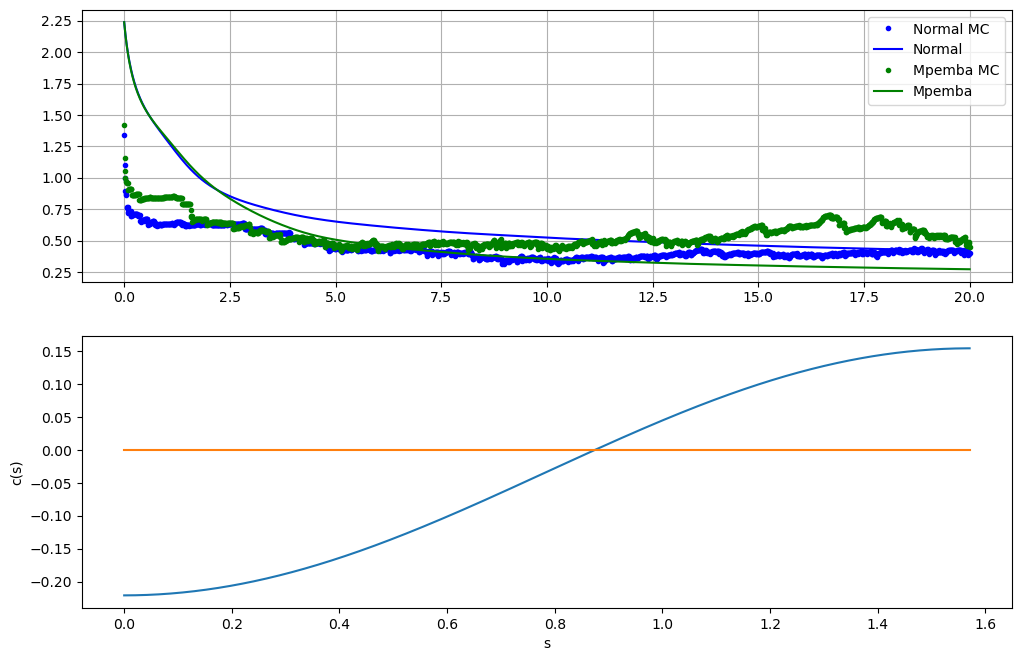

In [6]:
# Resolvemos el sistem usando Quantum Jump Montecarlo
print('Montecarlo')
nveces = 50
output1, tiempo, fotones1 = Resolver_Sistema(d01, H, [J], N, nveces, limite_t)
output2, tiempo, fotones2 = Resolver_Sistema(d02, H, [J], N, nveces, limite_t)

output1_int = q.mesolve(H, U_cambio*q.Qobj(d0)*U_cambio.dag(), tiempo, [J])
output2_int = q.mesolve(q.Qobj(H.full()), q.Qobj(d02), tiempo, [q.Qobj(J.full())])

# Estado estacionario
est = q.steadystate(q.Qobj(H), [q.Qobj(J)])

# Obtenemos distancia Hilbert Schmdit
vector1, vector2 = [], []
for i in range(len(output1)):
    x1 = output1[i]-est
    x2 = output2[i]-est
    vector1.append(np.sqrt((x1.dag()*x1).tr()))
    vector2.append(np.sqrt((x2.dag()*x2).tr()))
    
vector1_int, vector2_int = [], []
for i in range(len(output1_int.states)):
    x1 = output1_int.states[i] - est
    x2 = output2_int.states[i] - q.Qobj(est.full())
    vector1_int.append(np.sqrt(np.trace(x1.dag()*x1)))
    vector2_int.append(np.sqrt(np.trace(x2.dag()*x2)))

#fin = time.time()
#print('Tiempo: ' + str(fin-inicio))

# Representamos todo
fig = plt.figure(figsize = (12, 12))

# Distancia de Hilbert Schmidt
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tiempo, vector1, 'b.', label = 'Normal MC')
ax1.plot(tiempo, vector1_int, 'b-', label = 'Normal')

ax1.plot(tiempo, vector2, 'g.', label = 'Mpemba MC')
ax1.plot(tiempo, vector2_int, 'g-', label = 'Mpemba')

ax1.grid(True)
ax1.legend()

# Overlap
ax2 = fig.add_subplot(3, 1, 2)
s = np.linspace(0, 0.5*np.pi, 1000)
c_s = vals_l[0]*np.cos(s)**2 + vals_l[1]*np.sin(s)**2
ax2.plot(s, c_s)
ax2.plot(s, np.zeros_like(c_s))

ax2.set_xlabel('s')
ax2.set_ylabel('c(s)')

# Parte de distribucion de fotones
#ax3 = fig.add_subplot(3, 1, 3)

plt.show()